In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

In [3]:
# Load data
stocks_data = pd.read_pickle('data/nasdaq100_6y.pkl')
index_data = pd.read_pickle('data/nasdaq100_index_6y.pkl')
assets_names = stocks_data.columns.values

data_assets = stocks_data
data_index = index_data

print("Stocks data (time series) shape: {shape}".format(shape=stocks_data.shape))
print("Index data (time series) shape: {shape}".format(shape=index_data.shape))

stocks_data.head()

Stocks data (time series) shape: (1512, 91)
Index data (time series) shape: (1512,)


,ATVI,ADBE,AMD,ALGN,GOOGL,GOOG,AMZN,AAL,AMGN,ADI,...,VRSN,VRSK,VRTX,WBA,WDAY,WDC,WLTW,WYNN,XEL,XLNX
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-30,37.931797,95.279999,2.98,66.099998,790.299988,771.000000,689.070007,40.901630,137.723129,49.810318,...,88.139999,76.025185,126.400002,72.629318,80.279999,52.720818,118.801224,62.168110,30.473986,43.330223
2015-12-31,37.239155,93.940002,2.87,65.849998,778.010010,758.880005,675.890015,40.471584,136.913467,48.726913,...,87.360001,75.407249,125.830002,71.595238,79.680000,51.823299,117.903053,62.666264,30.063749,42.542248
2016-01-04,36.190571,91.970001,2.77,64.269997,759.440002,741.840027,636.989990,39.095459,133.548172,47.951786,...,83.949997,73.857529,122.889999,69.821350,77.760002,52.125347,114.528839,62.285854,29.887941,41.482540
2016-01-05,35.728809,92.339996,2.75,64.949997,761.530029,742.580017,633.789978,38.722763,133.404785,47.599461,...,81.410004,73.592690,123.449997,67.988579,77.239998,51.900967,115.316803,63.463291,30.189337,42.098431
2016-01-06,35.392109,91.019997,2.51,64.870003,759.330017,743.619995,632.650024,39.401268,132.181839,45.573589,...,81.019997,73.210167,122.230003,66.946083,74.400002,50.744545,115.316803,60.175549,30.507462,41.328568


In [4]:
# Split data
n_train = int(data_assets.shape[0]*0.8)

# Stocks data
X_train = data_assets.values[:n_train, :]
X_test = data_assets.values[n_train:, :]

# Index data
index_train = data_index[:n_train]
index_test = data_index[n_train:]

In [5]:
# Normalize data
scaler = MinMaxScaler([0, 1])
# Stocks data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# Index data
scaler_index = MinMaxScaler([0, 1])
index_train = scaler_index.fit_transform(index_train[:, np.newaxis])
index_test = scaler_index.fit_transform(index_test[:, np.newaxis])

/opt/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/opt/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


In [6]:
# Generate corrupted series by adding noise with normal distribution
noise_factor = 0.05
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# Clip corrupter data
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

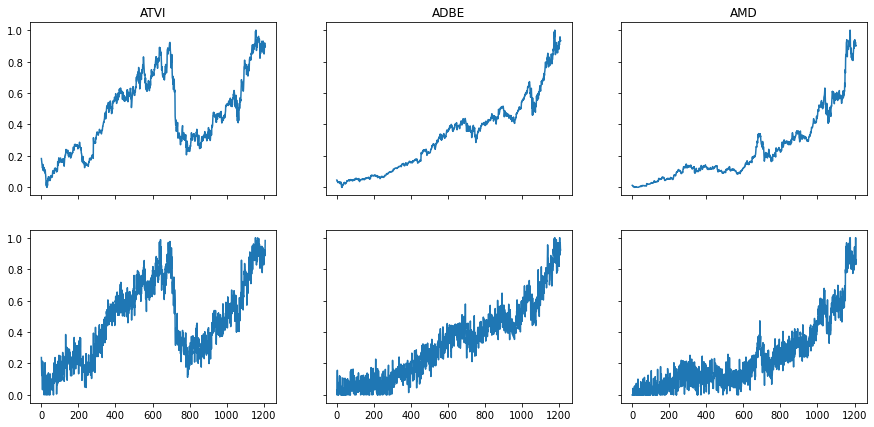

In [7]:
# Visualize corrupted data
f, axarr = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,7))

# Asset 1
axarr[0,0].plot(X_train[:, 0])
axarr[0,0].set_title(assets_names[0])
axarr[1,0].plot(X_train_noisy[:, 0])

# Asset 2
axarr[0,1].plot(X_train[:, 1])
axarr[0,1].set_title(assets_names[1])
axarr[1,1].plot(X_train_noisy[:, 1])

# Asset 3
axarr[0,2].plot(X_train[:, 2])
axarr[0,2].set_title(assets_names[2])
axarr[1,2].plot(X_train_noisy[:, 2])

plt.show()
#plt.savefig('denoisingAE_noisydata.png', bbox_inches='tight')

In [8]:
## Autoencoder - Keras

# Network hyperparameters
n_inputs = X_train.shape[1]

# Training hyperparameters
epochs = 50
batch_size = 1

# Define model
input = Input(shape=(n_inputs,))
# Encoder Layers
encoded = Dense(4, input_shape=(n_inputs,), activation='relu')(input)
decoded = Dense(n_inputs, activation='sigmoid')(encoded)

# Encoder
encoder = Model(input, encoded)

# Autoencoder
model = Model(input, decoded)

In [9]:
# Compile autoencoder
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91)]              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 368       
_________________________________________________________________
dense_1 (Dense)              (None, 91)                455       
Total params: 823
Trainable params: 823
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Fit the model
history = model.fit(X_train_noisy,
                    X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1
                    )

Epoch 1/50
1209/1209 [==============================] - 1s 645us/step - loss: 0.0490
Epoch 2/50
1209/1209 [==============================] - 1s 767us/step - loss: 0.0152
Epoch 3/50
1209/1209 [==============================] - 1s 729us/step - loss: 0.0117
Epoch 4/50
1209/1209 [==============================] - 1s 853us/step - loss: 0.0104
Epoch 5/50
1209/1209 [==============================] - 1s 788us/step - loss: 0.0088
Epoch 6/50
1209/1209 [==============================] - 1s 671us/step - loss: 0.0081
Epoch 7/50
1209/1209 [==============================] - 1s 869us/step - loss: 0.0073
Epoch 8/50
1209/1209 [==============================] - 1s 955us/step - loss: 0.0071
Epoch 9/50
1209/1209 [==============================] - 1s 790us/step - loss: 0.0067
Epoch 10/50
1209/1209 [==============================] - 1s 950us/step - loss: 0.0064
Epoch 11/50
1209/1209 [==============================] - 1s 633us/step - loss: 0.0064
Epoch 12/50
1209/1209 [==============================] - 1s 738

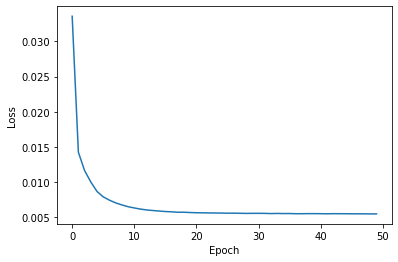

In [11]:
# Visualize loss history
plt.figure()
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
#plt.savefig('images/denoisingAE_loss.png', bbox_inches='tight')

In [12]:
#from keras.models import model_from_json
#
## Save model
## serialize model to JSON
#model_json = model.to_json()
#with open("models/denoisingAE_model.json", "w") as json_file:
#    json_file.write(model_json)
## serialize weights to HDF5
#model.save_weights("models/denoisingAE_model.h5")

In [13]:
## Load model
## load json and create model
#json_file = open('models/denoisingAE_model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#model = model_from_json(loaded_model_json)
## load weights into new model
#model.load_weights("models/denoisingAE_model.h5")

In [14]:
# Evaluate model
score_train = model.evaluate(X_train_noisy, X_train, batch_size=batch_size)
score_test = model.evaluate(X_test_noisy, X_test, batch_size=batch_size)

print('Training MSE: %.8f' %score_train)
print('Training MSE: %.8f' %score_test)

303/303 [==============================] - 0s 660us/step - loss: 0.0482
Training MSE: 0.00544322
Training MSE: 0.04818711


In [15]:
# Obtain reconstruction of the stocks
X_train_pred = model.predict(X_train_noisy)
X_test_pred = model.predict(X_test_noisy)

error = np.mean(np.abs(X_train - X_train_pred)**2, axis=0)
print('Training MSE: %.8f' %np.mean(error))

error_test = np.mean(np.abs(X_test - X_test_pred)**2, axis=0)
print('Testing MSE: %.8f' %np.mean(error_test))

Training MSE: 0.00544322
Testing MSE: 0.04818712


In [16]:
# Sort stocks by reconstruction error
ind = np.argsort(error)
sort_error = error[ind]
sort_assets_names = assets_names[ind]

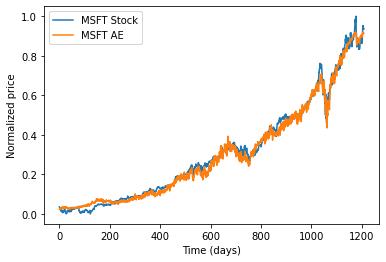

In [17]:
# Plot
i = 0
plt.figure()
plt.plot(X_train[:, ind[i]], label=assets_names[ind[i]] + ' Stock')
plt.plot(X_train_pred[:, ind[i]], label=assets_names[ind[i]] + ' AE')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/denoisingAE_' + assets_names[ind[i]] + '.eps', bbox_inches='tight')

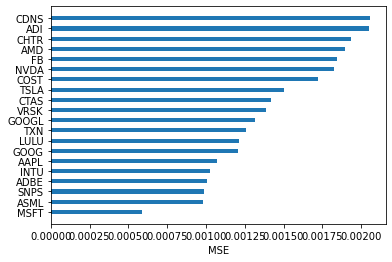

In [18]:
# Barplot
plt.figure()
plt.barh(2*np.arange(len(error[:20])), error[ind[:20]], tick_label=assets_names[ind[:20]])
plt.xlabel('MSE')
#plt.xticks(rotation=25)
plt.show()
#plt.savefig('images/denoisingAE_MSEbar.png', bbox_inches='tight')

In [19]:
# Identify stocks
n = 5

portfolio_train = X_train_pred[:, ind[:n]]
portfolio_test = X_test_pred[:, ind[:n]]

# Create portfolio in-sample
tracked_index_insample = np.mean(portfolio_train, axis=1)

# Create portfolio out-sample
tracked_index_outofsample = np.mean(portfolio_test, axis=1)

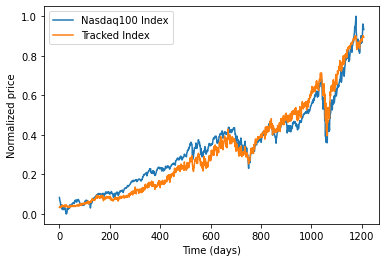

In [20]:
# In-sample
plt.figure()
plt.plot(index_train, label='Nasdaq100 Index')
plt.plot(tracked_index_insample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/denoisingAE_insample.png', bbox_inches='tight')

In [21]:
# Correlation coefficient (in-sample)
corr_train = np.corrcoef(index_train.squeeze(), tracked_index_insample)[0, 1]
print('Correlation coefficient (in-sample): %.8f' %corr_train)

Correlation coefficient (in-sample): 0.98457071


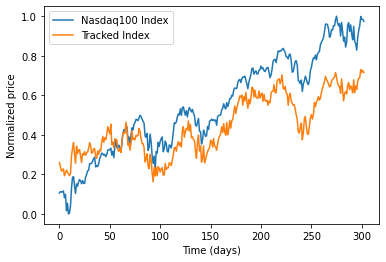

In [22]:
# Plot tracked index (out-of-sample)
plt.figure()
plt.plot(index_test, label='Nasdaq100 Index')
plt.plot(tracked_index_outofsample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/denoisingAE_outofsample.png', bbox_inches='tight')

In [23]:
# Correlation coefficient (out-of-sample)
corr_test = np.corrcoef(index_test.squeeze(), tracked_index_outofsample)[0, 1]
print('Correlation coefficient: %.8f' %corr_test)

Correlation coefficient: 0.92262988
